In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textparser import TextParser
import nltk

## Vectorizing tutorial

In [2]:
raw = pd.read_csv('nrao_projects.csv')
raw.head()

,project_code,project_title,project_abstract,fs_type,target
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,line,1
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,line,1
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,line,1
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line,1
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,line,1


In [3]:
raw['text'] = raw.project_title.str.strip() + ' ' + raw.project_abstract.str.strip()    # strip leading or trailing spaces
raw['text'] = raw.text.str.lower()                                                      # convert to lower case

In [4]:
raw = raw.drop(['project_code', 'project_title', 'project_abstract', 'fs_type'], axis=1)

In [5]:
NGRAM_RANGE = (1, 10)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 1

tfidf_vectorizer = TfidfVectorizer()
x_train = tfidf_vectorizer.fit_transform(raw['text'].astype('U'))

In [6]:
test = pd.DataFrame(tfidf_vectorizer.get_feature_names_out())

In [7]:
test[1989:]

,0
1989,abandance
1990,abandunce
1991,abcs
1992,abell
1993,aberrant
...,...
14530,zyjhk
14531,µjy
14532,µm
14533,λcdm


In [8]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

# Notes
## Text Standardization
* Respect and build thoughtful OHCO for overall text model

### Tentative Language Model Deliverable
* LIB table (collection of proposal IDs, titles, abstracts, title+abstract, possible classification but maybe this could be reseved for a different table)
* DOC table (gather from token table)
* TOKEN table ()
* VOCAB table ()

### OHCO Outline
* Combine title and abstract
* Corpus is built of combined titles and abstracts, i.e. all proposal titles and abstracts
* Treat combined title and abstract as document
* **CURRENTLY IT APPEARS AS THOUGH ABSTRACTS ARE FORMATTED TO ONE LARGE PARAGRAPH THOUGH THIS REQUIRES EDA CONFIRMATION**
* **IT APPEARS AS THOUGH TITLES ARE ONE SENTENCE BUT THIS REQURES EDA CONFIRMATION**
* Combine title and abstract on specific (unique) character to ensure full title is first sentence of document
* THIS GIVES THE FOLLOWING OHCO
    * CORPUS (all projects)
    * DOCUMENT (individual project, title and abstract combined)
    * SENTENCE (title is first sentence, abstract are following sentences)
    * TOKEN (see notes below on tokenization)

### Tokenization notes
* What to do with numbers?
* Lower case everything
* Strip leading and trailing space

## Language Model

### LIB Table

In [9]:
LIB = pd.read_csv('nrao_projects.csv')
LIB['project_title_abstract'] = LIB['project_title'] + ". " + LIB['project_abstract']
LIB['project_title_abstract'] = LIB['project_title_abstract'].astype(str)
LIB = LIB.drop(['fs_type', 'target'], axis=1)
LIB.head()

,project_code,project_title,project_abstract,project_title_abstract
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,Fifty AU STudy of the chemistry in the disk/en...
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,COMPASS: Complex Organic Molecules in Protosta...
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,ALCHEMI: the ALMA Comprehensive High-resolutio...
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,ALMA JELLY - Survey of Nearby Jellyfish and Ra...
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,Bulge symmetry or not? The hidden dynamics of ...


In [34]:
LIB.shape

(4528, 4)

### Token Table

The following is done by using a modified version of textparser.py from Professor Alvarado (5001: Exploratory Text Analytics)

**THIS CURRENTLY ONLY WORKS WITH NLTK**

In [10]:
def tokenize_collection(LIB):
    books = []
    for x in range(len(LIB.index)):
        # Create object
        text = TextParser(LIB.iloc[x]['project_title_abstract'],use_nltk=True)

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.parse_tokens();

        # Name things
        text.TOKENS['project_code'] = LIB.iloc[x]['project_code']
        text.TOKENS = text.TOKENS.reset_index().set_index(['project_code'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS

In [11]:
CORPUS = tokenize_collection(LIB)

Done


In [18]:
CORPUS['pos_group'] = CORPUS.pos.str[:2]
CORPUS.head(600)

pos_tuple   pos  token_str  \
project_code   sent_num token_num                                     
2011.0.00010.S 0        0                (The, DT)    DT        The   
                        1          (Physics, NNPS)  NNPS    Physics   
                        2                (and, CC)    CC        and   
                        3          (Chemisty, NNP)   NNP   Chemisty   
                        4                 (of, IN)    IN         of   
...                                            ...   ...        ...   
2011.0.00020.S 2        2               (goal, NN)    NN       goal   
                        3                (is, VBZ)   VBZ         is   
                        4                 (to, TO)    TO         to   
                        5          (establish, VB)    VB  establish   
                        6                  (a, DT)    DT          a   

                                    term_str pos_group  
project_code   sent_num token_num                       
2011.0.00010.S 0        0                the        DT  
                        1            physics        NN  
                        2                and        CC  
                        3           chemisty        NN  
                        4                 of        IN  
...                                      ...       ...  
2011.0.00020.S 2        2               goal        NN  
                        3                 is        VB  
                        4                 to        TO  
                        5          establish        VB  
                        6                  a        DT  

[600 rows x 5 columns]

In [33]:
CORPUS.shape

(861689, 5)

In [35]:
# Average number of words per title + abstract
CORPUS.shape[0] /LIB.shape[0] 

190.30234098939928

In [15]:
CORPUS[CORPUS.term_str == ''].token_str.value_counts()

token_str
=        185
>        154
~        147
&        133
<        123
+         49
/         26
(~        26
(<        22
(>        15
*         13
?.        11
%         11
),        10
–          8
>=         4
(=         3
%)         3
×          3
+/         3
∼          2
−          2
~<         2
(>>        2
(!!).      2
—          2
(+/        2
].         1
(!)        1
(<=        1
...),      1
[          1
],         1
>>         1
~>         1
);         1
))         1
@          1
(~<        1
>~         1
$>         1
(+         1
<~         1
($<$       1
($>$       1
$<         1
($<        1
[...       1
Name: count, dtype: int64

## VOCAB TABLE

In [16]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB.head()

,n,n_chars,p,i
term_str,,,,
,984,0,0.001143,9.772891
0,1167,1,0.001356,9.526817
00,2,2,0.000002,18.715406
000,6,3,0.000007,17.130443
00001,1,5,0.000001,19.715406


## VOCAB POS Ambiguity

In [19]:
VOCAB_POS = VOCAB.copy(deep=True)
VOCAB_POS['n_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB_POS['cat_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))

In [20]:
VOCAB_POS['n_pos'] = CORPUS[['term_str','pos']].value_counts().unstack().count(1)
VOCAB_POS['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [21]:
VOCAB_POS

,n,n_chars,p,i,n_pos_group,cat_pos_group,n_pos,cat_pos
term_str,,,,,,,,
,984,0,0.001143,9.772891,7,"{RB, CD, FW, VB, NN, CC, JJ}",12,"{VBZ, CD, VBD, RB, FW, NNS, NNP, VBP, VB, NN, ..."
0,1167,1,0.001356,9.526817,4,"{CD, VB, NN, JJ}",5,"{CD, VBP, VB, NN, JJ}"
00,2,2,0.000002,18.715406,2,"{CD, NN}",2,"{CD, NN}"
000,6,3,0.000007,17.130443,1,{CD},1,{CD}
00001,1,5,0.000001,19.715406,1,{CD},1,{CD}
...,...,...,...,...,...,...,...,...
η,1,1,0.000001,19.715406,1,{NN},1,{NNP}
λ,1,1,0.000001,19.715406,1,{NN},1,{NNP}
λcdm,1,4,0.000001,19.715406,1,{NN},1,{NNP}


## Interlude: Stopword Stats

In [23]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [24]:
VOCAB_POS['stop'] = VOCAB_POS.index.map(sw.dummy)
VOCAB_POS['stop'] = VOCAB_POS['stop'].fillna(0).astype('int')

In [25]:
a = VOCAB_POS.groupby('stop').n_chars.mean()
b = VOCAB_POS.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [26]:
pd.concat([a,b], axis=1)

,n_chars,n_pos
stop,,
0,7.127717,1.721405
1,3.584746,5.008475


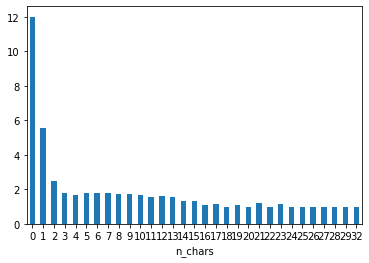

In [27]:
VOCAB_POS.groupby('n_chars').n_pos.mean()\
    .sort_index().plot.bar(rot=0);

In [28]:
VOCAB_POS[VOCAB_POS.stop == True].sort_values('n_pos', ascending=False)[['n_pos','cat_pos']].head(20)

,n_pos,cat_pos
term_str,,
a,13,"{IN, RB, VBD, RP, PDT, NNS, DT, VBN, NNP, VBP,..."
or,13,"{VBZ, IN, RP, VBD, PDT, NNS, VBN, NNP, VBP, VB..."
i,13,"{IN, RB, VBD, PRP, PDT, VBN, NNP, RBR, VBP, VB..."
that,12,"{IN, RB, VBD, WDT, JJ, NNS, WP, VBP, VB, NN, V..."
and,12,"{IN, VBZ, RB, VBD, NNS, VBN, NNP, VBP, VB, NN,..."
with,10,"{IN, CD, VBD, NNP, JJR, NNS, VBP, NN, VBZ, JJ}"
the,10,"{RB, VBD, FW, NNS, DT, NNP, VBP, NN, VBZ, JJ}"
so,10,"{RB, IN, VBD, WDT, VBN, NNP, VBP, VB, NN, JJ}"
to,10,"{RB, IN, VBD, NNP, NNS, TO, VBP, VB, NN, JJ}"


### Add Stems

In [29]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB_POS_STEM = VOCAB_POS.copy(deep=True)
VOCAB_POS_STEM['stem_porter'] = VOCAB_POS_STEM.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB_POS_STEM['stem_snowball'] = VOCAB_POS_STEM.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB_POS_STEM['stem_lancaster'] = VOCAB_POS_STEM.apply(lambda x: stemmer3.stem(x.name), 1)

In [30]:
VOCAB_POS_STEM.sample(10)

,n,n_chars,p,i,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,
enveloppe,1,9,0.000001,19.715406,1,{NN},1,{NN},0,envelopp,envelopp,envelop
latter,33,6,0.000038,14.671012,2,"{NN, JJ}",3,"{JJR, NN, JJ}",0,latter,latter,lat
estimators,3,10,0.000003,18.130443,2,"{VB, NN}",3,"{VBP, NN, NNS}",0,estim,estim,estim
12maca,1,6,0.000001,19.715406,1,{CD},1,{CD},0,12maca,12maca,12maca
occurrence,30,10,0.000035,14.808515,1,{NN},1,{NN},0,occurr,occurr,occur
afford,3,6,0.000003,18.130443,1,{VB},1,{VB},0,afford,afford,afford
oifir,1,5,0.000001,19.715406,1,{NN},1,{NNP},0,oifir,oifir,oifir
841,1,3,0.000001,19.715406,1,{NN},1,{NN},0,841,841,841
ablation,2,8,0.000002,18.715406,1,{NN},1,{NN},0,ablat,ablat,abl


In [31]:
VOCAB_POS_STEM[VOCAB_POS_STEM.stem_porter != VOCAB_POS_STEM.stem_snowball]

,n,n_chars,p,i,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,
001s,1,4,0.000001,19.715406,1,{JJ},1,{JJ},0,001,001s,001s
025kms,1,6,0.000001,19.715406,1,{CD},1,{CD},0,025km,025kms,025kms
02kms,1,5,0.000001,19.715406,1,{NN},1,{NN},0,02km,02kms,02kms
030s,2,4,0.000002,18.715406,1,{CD},1,{CD},0,030,030s,030s
032kms,1,6,0.000001,19.715406,1,{NN},1,{NNP},0,032km,032kms,032kms
...,...,...,...,...,...,...,...,...,...,...,...,...
yearly,1,6,0.000001,19.715406,1,{JJ},1,{JJ},0,yearli,year,year
ymcs,17,4,0.000020,15.627943,2,"{VB, NN}",4,"{NNP, VBP, NN, NNS}",0,ymc,ymcs,ymc
yrs,4,3,0.000005,17.715406,1,{NN},1,{NN},0,yr,yrs,yr


In [32]:
VOCAB_POS_STEM.shape

(16913, 12)